<a href="https://colab.research.google.com/github/MUmairBaig/NLP/blob/main/nlpdemystified_word_vectors_c2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Demystified | Word Vectors
https://nlpdemystified.org<br>
https://github.com/futuremojo/nlp-demystified<br><br>
Course module for this demo: https://www.nlpdemystified.org/course/word-vectors

**IMPORTANT**<br>
Enable **GPU acceleration** by going to *Runtime > Change Runtime Type*. Keep in mind that, on certain tiers, you're not guaranteed GPU access depending on usage history and current load.
<br><br>
Also, if you're running this in the cloud rather than a local Jupyter server on your machine, then the notebook will *timeout* after a period of inactivity.
<br><br>
Refer to this link on how to run Colab notebooks locally on your machine to avoid this issue:<br>
https://research.google.com/colaboratory/local-runtimes.html

To demonstrate word vectors, we're going to use **Gensim** which we first encountered in the [topic modelling](https://www.nlpdemystified.org/course/topic-modelling) module.<br>

At the time of this recording, the default Gensim version in Colab was 3.X, so we'll first upgrade to 4.X.

In [68]:
# Upgrade gensim just in case.
!pip install -U gensim==4.*

In [69]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

**NOTE**<br>
In this notebook, we won't train standalone word embeddings from scratch. Rather, we'll:
1. Use *pretrained* embeddings in one model.
2. Train embeddings alongside another model.
<br>

If you want to try training standalone word embeddings, coding Skip-Gram With Negative Sampling (SGNS) from scratch shouldn't be too hard now that you know all the details. But I recommend just using the **Gensim** library instead:<br>
https://radimrehurek.com/gensim/models/word2vec.html<br>
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html



# Using Pretrained, Third-Party Vectors

There are a variety of pretrained, static word vector packages out there. In this section, we'll use the **Google News** vectors, a collection of three million, 300-dimension word vectors trained from three billion words from a Google News corpus (circa 2015).

We'll need to first download the actual word vectors. It's over a gigabyte in size but will fit within our environment.

In [70]:
!gdown "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"

Downloading...
From (original): https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku
From (redirected): https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku&confirm=t&uuid=ab3ea30b-dcc7-44d0-989c-f0f5fd874585
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:34<00:00, 47.4MB/s]


In [71]:
embedding_file = './GoogleNews-vectors-negative300.bin.gz'

Next, we'll have **gensim** load the vectors through the **KeyedVectors** module which will enable us to look up vectors by tokens and indices.<br>
https://radimrehurek.com/gensim/models/keyedvectors.html
<br><br>
To save time and space, we'll limit ourselves to 200,000 word vectors for now.

In [72]:
%%time
word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True, limit=200000)

CPU times: user 3.57 s, sys: 199 ms, total: 3.76 s
Wall time: 5.06 s


Retrieving a word's vector is a matter of using a token as a key.

In [73]:
pizza = word_vectors['pizza']
print(f'Vector dimension: {pizza.shape}')

# The embedding for the word 'pizza'.
print(pizza)

Vector dimension: (300,)
[-1.25976562e-01  2.53906250e-02  1.66992188e-01  5.50781250e-01
 -7.66601562e-02  1.28906250e-01  1.02539062e-01 -3.94821167e-04
  1.21582031e-01  4.32128906e-02  1.72851562e-01 -6.83593750e-02
  3.41796875e-01  8.39843750e-02  6.68945312e-02  2.67578125e-01
 -3.71093750e-02 -5.56640625e-02  1.80664062e-01  1.90429688e-02
 -5.07812500e-02  9.03320312e-03  1.76757812e-01  6.49414062e-02
 -6.25000000e-02 -9.42382812e-02 -9.71679688e-02  4.00390625e-01
  1.15234375e-01  1.02539062e-01 -1.86767578e-02 -2.69531250e-01
  1.80664062e-01  1.25000000e-01 -3.17382812e-02 -5.49316406e-02
  3.45703125e-01 -1.57470703e-02  1.82390213e-05  2.07031250e-01
 -1.25976562e-01 -2.83203125e-01  2.00195312e-01  8.34960938e-02
 -4.73632812e-02 -3.11279297e-02 -2.61718750e-01  1.69921875e-01
 -2.02636719e-02  1.53320312e-01 -1.20605469e-01  3.75000000e-01
 -5.68847656e-02 -4.76074219e-03 -1.95312500e-01 -2.03125000e-01
  3.00781250e-01 -1.01074219e-01 -3.18359375e-01 -9.03320312e-02


We can get the cosine similarity between two words using the *similarity* method.
https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.similarity

In this case, we see words which we expect to be related have a higher similarity measure...

In [74]:
print(word_vectors.similarity('pizza', 'tomato'))
print(word_vectors.similarity('pizza', 'sauce'))
print(word_vectors.similarity('pizza', 'cheese'))

0.35505623
0.36959887
0.4708358


...compared to words we don't expect to be related.

In [75]:
print(word_vectors.similarity('pizza', 'gorilla'))
print(word_vectors.similarity('pizza', 'tree'))
print(word_vectors.similarity('pizza', 'yoga'))

0.108518735
0.11185602
0.14119941


Out-of-vocabulary (OOV) words thrown an exception. Bear in mind that looking up even common words here can result in an exception because we loaded only a subset of the vocabulary.

In [76]:
try:
  word_vectors['womblyboo']
except KeyError as e:
  print(e)

"Key 'womblyboo' not present"


We can compare two sentences by using *n_similarity* which computes the cosine similarity of two **sets** of words.
https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.n_similarity<br><br>
*n_similarity* expects a sentence as a list of words, hence the use of '.split()'. It'll take this list of words, calculate the average of its word vectors, and use the result as an embedding for the whole sentence.

In [77]:
word_vectors.n_similarity("dog bites man".split(), "canine nips human".split())

0.53146607

In [78]:
word_vectors.n_similarity("martian dolphins are hostile".split(), "i flunked calligraphy school".split())

0.1450578

One downside of this approach is that word order is thrown out, so two sentences with identical words which mean different things would score a perfect similarity score.

In [79]:
word_vectors.n_similarity("dog bites man".split(), "man bites dog".split())

1.0

Doing quick-and-dirty similarity measures like this is probably best if your corpus is domain-specific and similarity is based more on keywords. The more specific, the better.<br><br>
For example, a corpus of business news headlines would probably work well.

In [80]:
s1 = "Volkswagen intends to double electric car sales in China".lower().split()
s2 = "First Toyota with solid state battery will be hybrid".lower().split()
word_vectors.n_similarity(s1, s2)

0.52682734

The *most_similar* method returns the words with the closest vectors.<br>
https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar

In [81]:
word_vectors.most_similar(positive=['cell'], topn=10)

[('cells', 0.8180485367774963),
 ('Cells', 0.6146953105926514),
 ('Cell', 0.5321314930915833),
 ('cellular', 0.5272858142852783),
 ('tumor_cells', 0.5097643136978149),
 ('ES_cells', 0.4866572618484497),
 ('immune_cells', 0.4831920266151428),
 ('epithelial_cells', 0.47818055748939514),
 ('molecule', 0.47757473587989807),
 ('proteins', 0.4749472737312317)]

We can also combine vectors first, and retrieve the words most similar to their mean. Here, we're combining the vectors for 'cell' and 'phone' and retrieving the vectors closest to that result.

In [82]:
word_vectors.most_similar(positive=['cell', 'phone'], topn=10)

[('cell_phone', 0.6861391067504883),
 ('cellular', 0.6757438778877258),
 ('cellphone', 0.6633196473121643),
 ('telephone', 0.6474039554595947),
 ('Phone', 0.605189323425293),
 ('phones', 0.5896332859992981),
 ('cells', 0.585094690322876),
 ('cordless_phone', 0.5711769461631775),
 ('Cell', 0.5617641806602478),
 ('landline', 0.5467296242713928)]

Given a collection of words, the *doesn't_match* method returns the word that "doesn't go" with the rest (i.e. with the vector that's furthest away from the mean of all the other vectors).<br>
https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.doesnt_match

In [83]:
word_vectors.doesnt_match(["apple", "orange", "hamburger", "banana", "kiwi"])

'hamburger'

We can see the power of context in this example with 'Toyota' being correctly identified as the odd one out.

In [84]:
word_vectors.doesnt_match(["Microsoft", "Apple", "Toyota", "Amazon", "Netflix", "Google"])

'Toyota'

Visualizing word vectors is straight-forward and can offer insights into what kind of contexts the training algorithm picked up.<br><br>
Because these word vectors have a dimension of 300, we need to reduce them down to two dimensions to plot them on a regular graph. This can be done through **Principal Components Analysis (PCA)**:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html<br>
<br>
Here, we're plotting the words we considered in the slides.

In [85]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=128)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

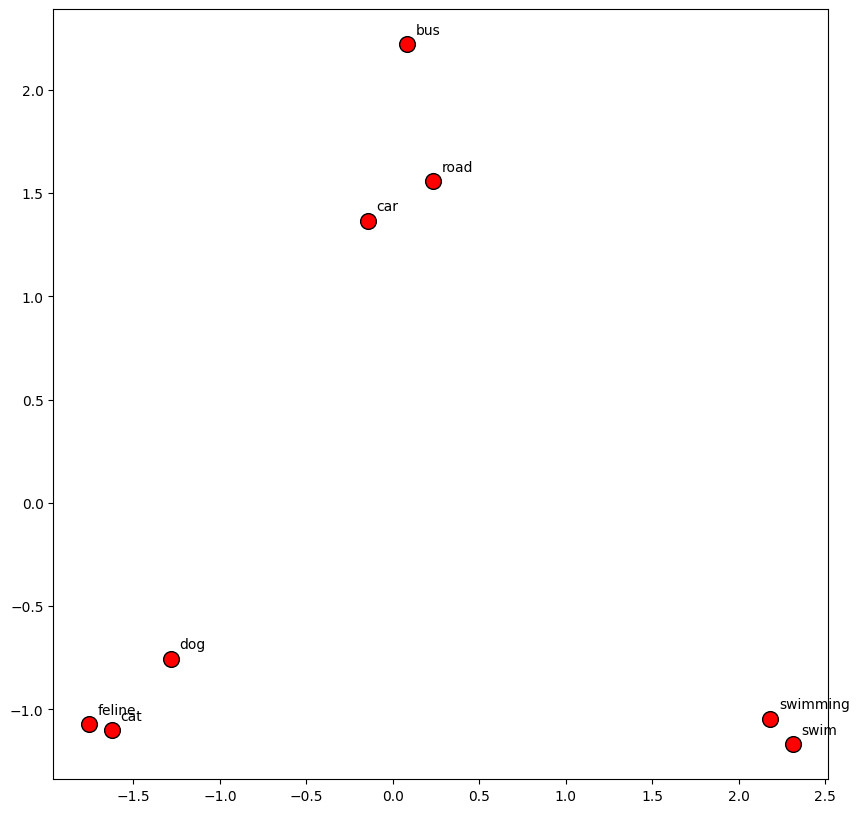

In [86]:
display_pca_scatterplot(word_vectors, ['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus'])

We can even solve analogies (to a limited extent) with vector arithmetic.<br><br>
Here, we're solving the analogy:<br>
_Rome is to Italy as London is to __________.<br><br>
Arithmetically, this is Italy + London - Rome.


In [87]:
word_vectors.most_similar(positive=['Italy', 'London'], negative=['Rome'], topn=3)

[('UK', 0.6230568885803223),
 ('Britain', 0.6016390323638916),
 ('United_Kingdom', 0.534345805644989)]

Visualizing it can help with geometric intuition.

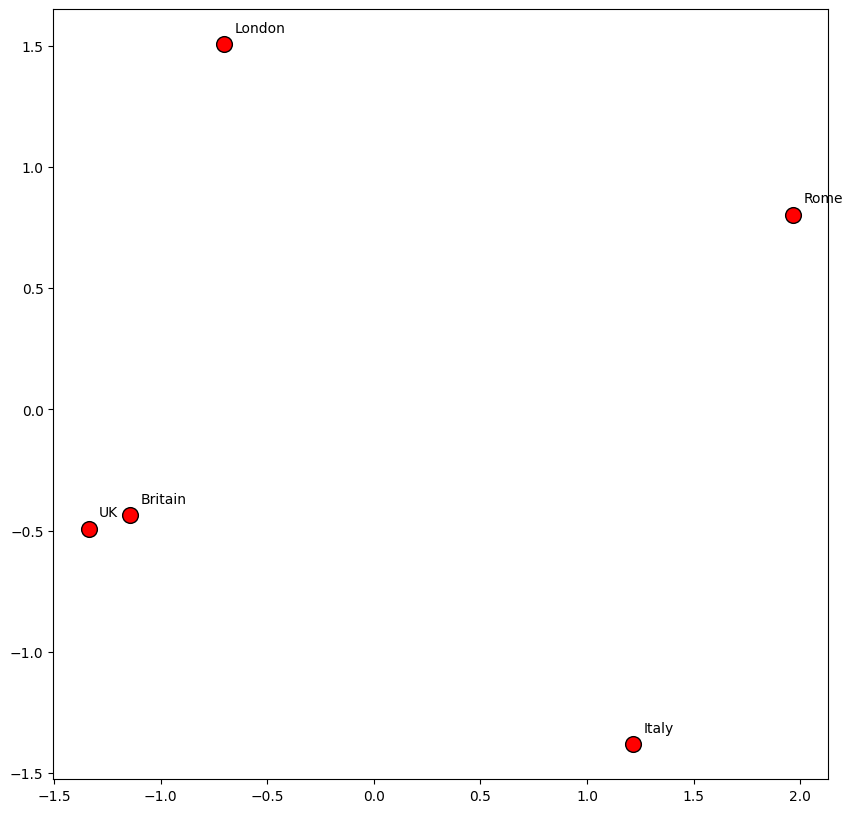

In [88]:
display_pca_scatterplot(word_vectors, ['Rome', 'Italy', 'London', 'Britain', 'UK'])

# Using Pretrained Word Vectors for Classification

In this section, we'll train a **Keras** model to use these Google News vectors to perform sentiment analysis on a bunch of **Yelp** reviews.
<br><br>
For this model, we'll increase the number of word vectors loaded to 1,000,000.



In [89]:
%%time
word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True, limit=1000000)

CPU times: user 18 s, sys: 1.12 s, total: 19.1 s
Wall time: 28.7 s


The dataset we'll use is *Yelp Polarity Reviews*, a collection of ~600,000 reviews for both training and testing.<br><br>
The original Yelp reviews use a five-star rating system. The ratings in this dataset have been modified to simply be negative (label==1) or positive (label==2).<br>
https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews<br><br>
Tensorflow comes with a datasets loader but we're going to download the file manually and process the data ourselves for completeness.

In [90]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz"

--2024-06-15 08:45:10--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.206, 52.216.48.112, 52.216.165.61, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.206|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Unzipping the archive results in *train.csv* and *test.csv* files placed in the default *contents* folder of our environment.

In [91]:
!tar xvzf /root/input/yelp_review_polarity_csv.tgz

# Show current working directory.
!pwd

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv
/content


The **Pandas** library makes it simple to load a CSV file into memory and manipulate the data.<br>
https://pandas.pydata.org/<br>
https://pandas.pydata.org/docs/<br>
https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html?highlight=read_csv

Here, we're loading the CSV into a Pandas **dataframe** (sort of like an in-memory table) and explicitly naming the columns.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html?highlight=dataframe#pandas.DataFrame

In [92]:
yelp_train = pd.read_csv('yelp_review_polarity_csv/train.csv', names=['sentiment', 'review'])
print(yelp_train.shape)

(560000, 2)


We can get a quick view of the data through the *head* method.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

In [93]:
yelp_train.head()

,sentiment,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


To save on training time, we'll train on 100,000 reviews rather than the full set. To do that, we'll shuffle the dataset using the *sample* method and *copy* the first 100,000 entries. The reason to shuffle first is to ensure we get a mix of reviews from a variety of businesses (in case the data is sorted in some way).<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html


In [94]:
TRAIN_SIZE = 100000
yelp_train = yelp_train.sample(frac=1, random_state=1)[:TRAIN_SIZE].copy()
print(yelp_train.shape)

(100000, 2)


The next thing to do is adjust the labels. This is a **binary classification problem**, so our model's output layer will be a single unit with a **sigmoid** activation function. This function's output will be between 0 and 1 which is then compared against the training label. But the labels are currently 1 for negative, and 2 for positive, which is going to cause problems when calculating the loss.<br><br>
So we'll simply replace the 1s with 0s, and 2s with 1s using the *replace* method.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
<br><br>
Alternatively, we could keep the labels as-is and treat this as a **multiclassification** problem with two labels and use a **softmax**, but we would then need to **one-hot encode** the labels (at least based on what we've learnt so far).


In [95]:
yelp_train['sentiment'].replace(to_replace=1, value=0, inplace=True)
yelp_train['sentiment'].replace(to_replace=2, value=1, inplace=True)

In [96]:
yelp_train.head()

,sentiment,review
39658,1,"omg, the grandma g's pizza with rosemary chick..."
330033,0,Microwaved food over over over seasoned gyro m...
238898,0,"While the food is good, the service leaves a l..."
453536,0,Called the Chandler PD about the sign spinner ...
555973,1,"Just took Ewok, my approx. 6 month old shih tz..."


As we've done throughout this course, we'll create train/validation splits.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [97]:
yelp_train_split, yelp_val_split = train_test_split(yelp_train, train_size=0.85, random_state=1)

In [98]:
# Set up training data.
train_reviews = yelp_train_split['review']
y_train = np.array(yelp_train_split['sentiment'])

# Set up validation data.
val_reviews = yelp_val_split['review']
y_val = np.array(yelp_val_split['sentiment'])

A quick sanity check to see how our data is distributed (e.g. balanced or skewed).

In [99]:
collections.Counter(y_train)

Counter({0: 42395, 1: 42605})

Because we're relying more on richer encodings (in this case, word vectors), we won't perform as much preprocessing this time around. We'll stick with using the regular Keras **tokenizer** and just filter out numbers and certain symbols.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer<br><br>
We'll also have the tokenizer limit itself to tokenizing only the most frequent 20,000 words. This way, the model will focus on the most frequent descriptive sentiment words.

In [100]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

Build the vocabulary.

In [101]:
%%time
tokenizer.fit_on_texts(train_reviews)

CPU times: user 8.03 s, sys: 38.7 ms, total: 8.06 s
Wall time: 8.13 s


The next step is to vectorize our reviews. In the [_Neural Network Foundations_](https://github.com/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_neural_networks_foundations.ipynb) notebook, we used the *texts_to_matrix* method to turn text into binary bags of words.<br><br>
Here, we're going to use the *text_to_sequences* method to turn each review into a sequence of integers, with each integer representing its corresponding token.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences



In [102]:
%%time
X_train = tokenizer.texts_to_sequences(train_reviews)

CPU times: user 6.92 s, sys: 60.5 ms, total: 6.98 s
Wall time: 7.13 s


In [103]:
# The first review in the training set, vectorized.
print(X_train[0])

[49, 14, 2224, 4199, 1981, 11, 2312, 16, 6, 59, 3042, 138, 5, 145, 1, 294, 1, 378, 370, 7, 8, 37, 6, 1, 120, 944, 16362, 1026, 33, 3014, 21, 1170, 12144, 3036, 1427, 5513, 56, 3214, 2, 106, 5514, 136, 886, 1, 2224, 268, 3, 90, 22, 1278, 944, 16362, 51, 183, 36, 60, 107, 3214, 9, 14, 795, 26, 351, 3, 148, 5, 150, 107, 65, 12, 47, 74, 1966, 1935, 42, 7, 1, 132, 5352, 24, 1918, 36, 5481, 21, 1, 11637, 1378, 1116, 6722, 13, 64, 262, 19603, 2, 312, 4, 1253, 3278, 5, 14, 362, 116, 6, 10, 1, 128, 271, 137, 2100, 7, 16, 14, 362, 2, 3, 148, 4, 156, 1694, 1047, 17, 147, 86, 323, 598, 1, 1103, 207, 1055, 51, 544, 783, 21, 1, 3872, 15, 26, 147, 17728, 2, 27, 148, 39, 15, 102, 993, 18, 1, 1364, 55, 1, 6722, 5481, 2, 60, 39, 249, 102, 30, 282, 8, 161, 4, 43, 189, 46, 9, 944, 16362, 5, 1338, 65, 10, 674, 3, 102, 598, 2, 47, 64, 90, 279, 48, 64, 86, 124, 174, 1, 128, 18, 4, 545, 303, 1072, 13078, 12751, 17, 18, 1, 766, 13, 14, 362, 2, 3, 24, 282, 172, 360, 10, 815, 9, 107, 3, 78, 113, 39, 1, 5352, 24,

We can look up the corresponding tokens using the tokenizer's *index_word* dict. Here are the tokens corresponding to the first three integers from the first vectorized review.

In [104]:
[tokenizer.index_word[x] for x in X_train[0][:3]]

['from', 'my', 'hospital']

We can also convert the integer sequence back to text using the *sequences_to_texts* method, and compare it against the original text.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#sequences_to_texts

In [105]:
# Review excerpt reconstructed from integer sequence.
tokenizer.sequences_to_texts([X_train[0]])[0][:300]

'from my hospital feedback form n nwhile this was an unpleasant experience to say the least the worst part of it all was the way dr haslett treated me doctors on previous shifts introduced themselves discussed their plans and said goodbye before leaving the hospital however i did not meet dr haslett '

In [106]:
# Original review text.
train_reviews.iloc[0][:300]

'From my hospital feedback form:\\n\\nWhile this was an unpleasant experience to say the least, the worst part of it all was the way Dr. Haslett treated me.  Doctors on previous shifts introduced themselves, discussed their plans and said goodbye before leaving the hospital.  However, I did not meet Dr'

Some models and situations require us to **pad** our sequences to the same length. While that's not the case here, it can still be beneficial to have all our inputs (and consequently, our batches) to be of uniform size to help with optimizations.<br><br>
In this case, we'll make all our reviews 200 tokens in length (in practice, you can choose a number based on some analysis). So the reviews longer than 200 tokens will be truncated, while the reviews shorter than 200 will be padded with zeroes.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [107]:
MAX_REVIEW_LEN = 200
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_REVIEW_LEN)

In [108]:
print(X_train[0])
print(X_train[1])

[ 1037   957     2   356    36   184   267    13    24   576    21    13
   132    73    47   944 16362   102    22   141     7     1   238    64
     6  5990     5     2    24     5    30  1743     7    75     1  5352
   184   267    64    24   106    28   238     3   278   102    23  2902
    17    22    13    22    10     4    31     3    24    68  2489     3
   102   494  8000    49     3    24    91   538  6781   136     2     3
     6    22   828     9     1 13837     7  3942     3     6   142    49
     1    46     3    24   419    25     1  2224     5   121     2  2019
     5   429   238   694    17   118   102   477  2019    80   169  1026
    38    13     1     7  3442    28  1248   227    10  1427    17    80
   376    59  5112    18   944 16362     3     6   531  5381    36    55
   169  4867     5    10   376     4   120     2    37     3   102    99
   141    55     6     1 15231     7  3942    64   161   226    14   803
     9     4   893     2  3308    33    27   103 15

Our training set is prepared. We can now also vectorize and pad our validation set.

In [109]:
X_val = tokenizer.texts_to_sequences(val_reviews)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_REVIEW_LEN)

Now we need to incorporate the Google News vectors (currently loaded into gensim) into our Keras model. What we'll do is create an embedding matrix that maps each tokenizer integer to its respective word vector.<br><br>
For example, here's the index for the word "good" from the Keras tokenizer and the word vector for "good" from gensim. We want a matrix which maps the index to the vector.


In [110]:
print(tokenizer.word_index['good'])

34


In [111]:
# Part of the vector for the word 'good'.
print(word_vectors['good'][:50])

[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891]


We'll create this embedding matrix by first initializing a matrix of zeros, then looping over every word in the tokenizer vocabulary and:
1. Checking if the word has a corresponding vector in gensim.
2. If it does, then copy the vector into the matrix row corresponding to the word's index.

In [112]:
# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1

# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()


In [113]:
# Quick visual check.
print(embedding_matrix[tokenizer.word_index['good']][:50])

[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891]


We're ready to build our first model using pretrained word vectors. The first layer we'll add is a Keras **embedding** layer which is essentially a trainable lookup table/matrix.<br>
https://keras.io/api/layers/base_layer/#layer-class<br>
https://keras.io/api/layers/core_layers/embedding/<br><br>
In this case, we'll populate the **embedding** layer with the embedding matrix we created, and set *trainable* to True. This means we'll allow the learning algorithm training the classification model to adjust/fine-tune the word vectors as needed for greater performance. This corresponds to one of the scenarios we covered in the slides.

In [114]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True
)

We'll use a simple architecture for this model. Each training example is a sequence of *integers* which gets converted to a sequence of *vectors* (embeddings), but subsequent layers are expecting one vector per review. So we're inserting a **GlobalAveragePooling1D** layer after the embedding layer to average out all the word vectors into a single vector, before sending it further into the network. For classification, this can be pretty effective as a base model approach.<br>
https://keras.io/api/layers/pooling_layers/global_average_pooling1d/<br>

There was no science behind choosing 128 units in the first hidden layer and 64 units in the second hidden layer. The intuition was that the signal would be distilled from 300 dimensions down to 128 dimensions, then down to 64 dimensions before going to output.



In [115]:
tf.random.set_seed(0)

model = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Here's an example of what's going to happen under the hood to turn review text into a single vector for the dense layers:

In [116]:
review = "fantastic papaya steak"
print(f"Review: {review}")

review_sequence = tokenizer.texts_to_sequences([review])
print(f"Review as sequence of integers: {review_sequence}")

review_embeddings = embedding_layer(np.array(review_sequence))
print(f"Review embeddings shape: (Batch size: {review_embeddings.shape[0]}, \
Sequence length: {review_embeddings.shape[1]}, \
Embedding size: {review_embeddings.shape[2]})")

# How our document will be presented to the rest of the neural network.
print(f"Average of embeddings (shape): {np.mean(review_embeddings, axis=1).shape}")

Review: fantastic papaya steak
Review as sequence of integers: [[543, 5844, 305]]
Review embeddings shape: (Batch size: 1, Sequence length: 3, Embedding size: 300)
Average of embeddings (shape): (1, 300)


When we call the model's *summary* method, note how there are no params for the **GlobalAveragePooling1D** layer.

In [117]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 300)          28023900  
                                                                 
 global_average_pooling1d_3  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_9 (Dense)             (None, 128)               38528     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 28070749 (107.08 MB)
Trainable params: 28070749 (107.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________

We won't use **early stopping** for this run. This way, we'll be able to compare metrics between the train and validation sets.

In [118]:
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/20
167/167 [==============================] - 23s 131ms/step - loss: 0.3999 - accuracy: 0.8133 - val_loss: 0.2296 - val_accuracy: 0.9148
Epoch 2/20
167/167 [==============================] - 13s 79ms/step - loss: 0.1889 - accuracy: 0.9302 - val_loss: 0.2057 - val_accuracy: 0.9221
Epoch 3/20
167/167 [==============================] - 12s 69ms/step - loss: 0.1547 - accuracy: 0.9436 - val_loss: 0.1999 - val_accuracy: 0.9230
Epoch 4/20
167/167 [==============================] - 7s 41ms/step - loss: 0.1328 - accuracy: 0.9528 - val_loss: 0.2147 - val_accuracy: 0.9191
Epoch 5/20
167/167 [==============================] - 8s 48ms/step - loss: 0.1216 - accuracy: 0.9575 - val_loss: 0.2244 - val_accuracy: 0.9183
Epoch 6/20
167/167 [==============================] - 5s 30ms/step - loss: 0.1123 - accuracy: 0.9612 - val_loss: 0.2273 - val_accuracy: 0.9194
Epoch 7/20
167/167 [==============================] - 6s 33ms/step - loss: 0.1037 - accuracy: 0.9644 - val_loss: 0.2359 - val_accuracy: 0.

In [119]:
def plot_train_vs_val_performance(history):
  training_losses = history.history['loss']
  validation_losses = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  epochs = range(1, len(training_losses) + 1)

  import matplotlib.pyplot as plt
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(15)
  fig.set_figwidth(15)
  fig.tight_layout(pad=5.0)

  # Plot training vs. validation loss.
  ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
  ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
  ax1.title.set_text('Training vs. Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # PLot training vs. validation accuracy.
  ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
  ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
  ax2.title.set_text('Training vs. Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()

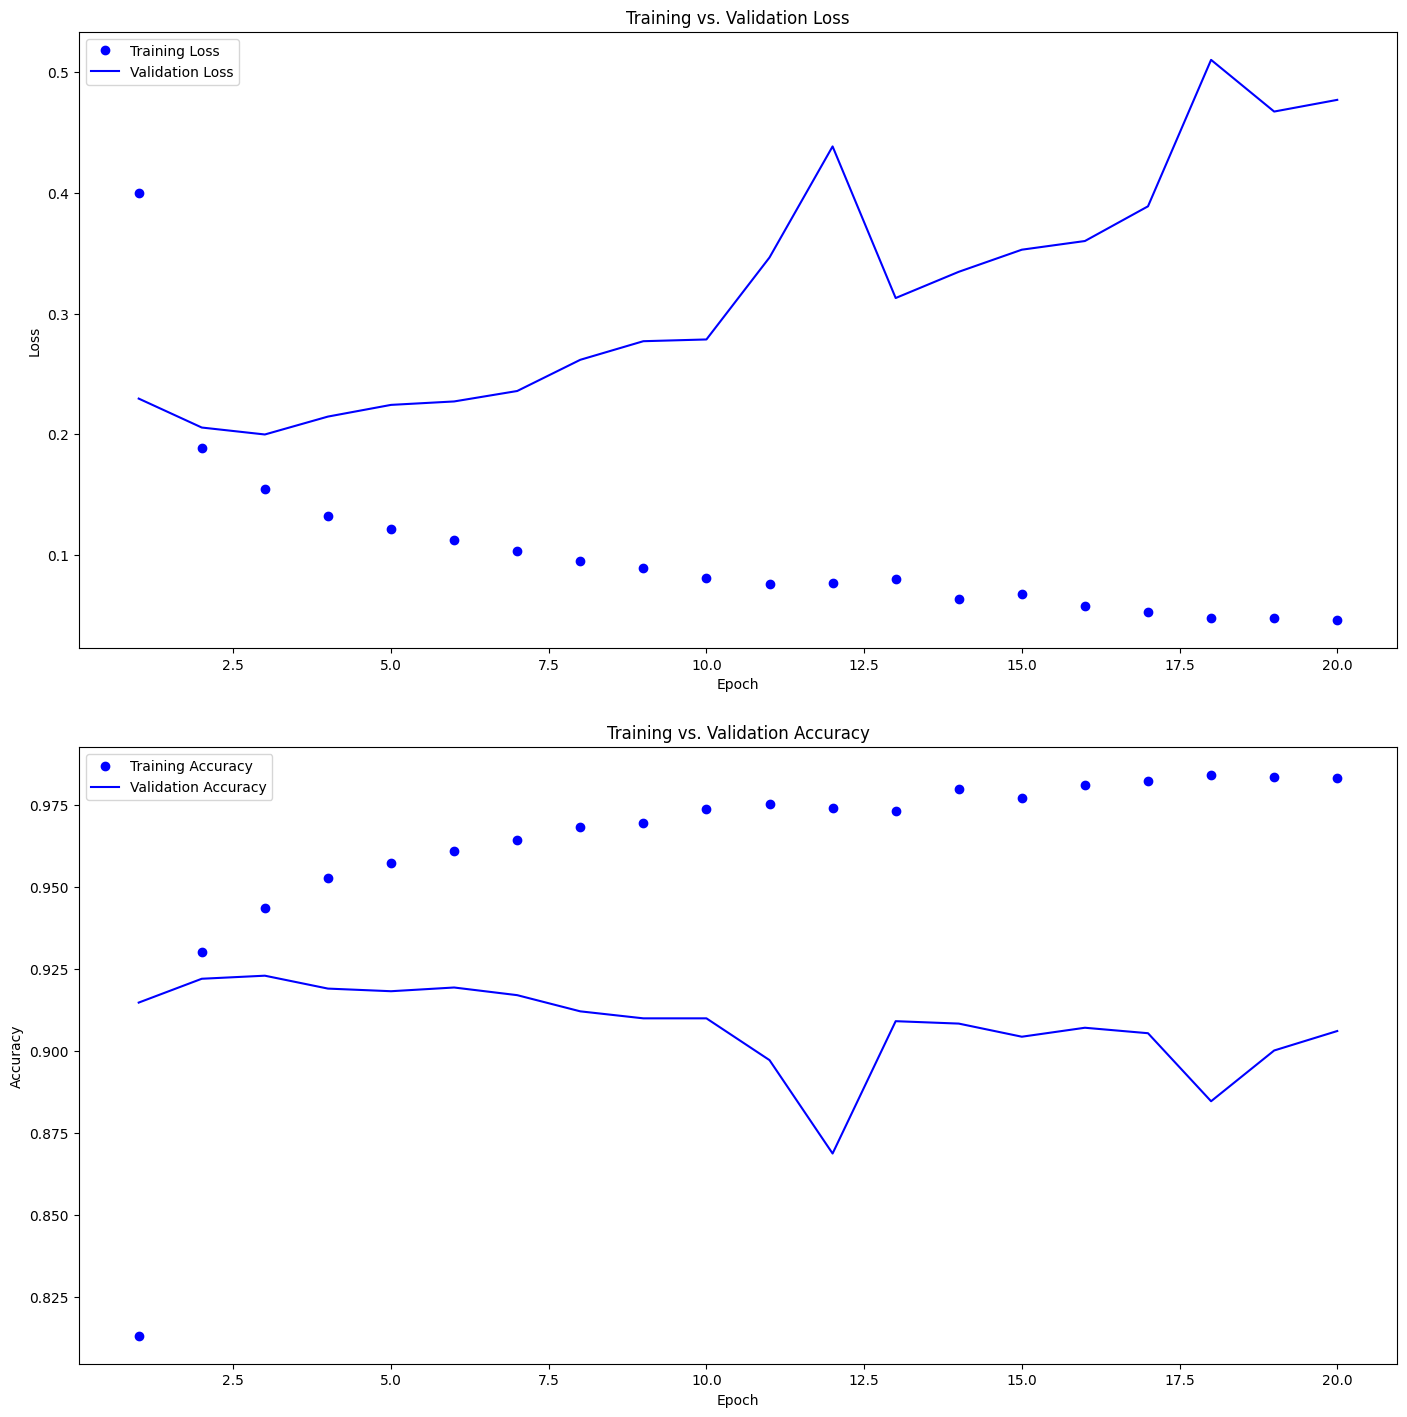

In [120]:
plot_train_vs_val_performance(history)

We'll initialize a new embedding layer and model and train for epochs equalling the point where we saw the validation loss diverge from the training loss.<br>

**NOTE**: We need to initialize a new embedding layer here because we set the *learnable* parameter to **True** in the previous embedding layer. This means the previous embeddings were almost certainly updated by the learning algorithm. So we're re-training a new model now with the original embeddings.

In [121]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True
)

model = keras.Sequential()
model.add(embedding_layer)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/3
167/167 [==============================] - 20s 112ms/step - loss: 0.3704 - accuracy: 0.8328 - val_loss: 0.2227 - val_accuracy: 0.9167
Epoch 2/3
167/167 [==============================] - 14s 83ms/step - loss: 0.1821 - accuracy: 0.9323 - val_loss: 0.1989 - val_accuracy: 0.9232
Epoch 3/3
167/167 [==============================] - 9s 54ms/step - loss: 0.1479 - accuracy: 0.9448 - val_loss: 0.1959 - val_accuracy: 0.9243


Now that we have a trained model, let's try it on the test data. As we did with the training data, we'll:
1. Replace the labels with 0 for negative sentiment, and 1 for positive.
2. Convert the reviews into a sequence of integers and pad/truncate each review to a fixed length.

In [122]:
yelp_test = pd.read_csv('yelp_review_polarity_csv/test.csv', names=['sentiment', 'review'])

In [123]:
yelp_test['sentiment'].replace(to_replace=1, value=0, inplace=True)
yelp_test['sentiment'].replace(to_replace=2, value=1, inplace=True)
yelp_test.head()

,sentiment,review
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


In [124]:
y_test = np.array(yelp_test['sentiment'])
print(y_test)

[1 0 1 ... 0 0 0]


In [125]:
X_test = tokenizer.texts_to_sequences(yelp_test['review'])

In [126]:
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_REVIEW_LEN)

In [127]:
model.evaluate(X_test, y_test)

1188/1188 [==============================] - 5s 4ms/step - loss: 0.1862 - accuracy: 0.9286


[0.1861937791109085, 0.9286052584648132]

Not bad for a conceptually simple model where we average out a review's word vectors, run it through a few plain hidden layers, and out through a sigmoid function with no regularization and just using defaults for model components (e.g. optimizer settings).<br><br>
We can now use the model for predictions.

In [128]:
def sentiment(reviews):
  seqs = tokenizer.texts_to_sequences(reviews)
  seqs = keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_REVIEW_LEN)
  return model.predict(seqs)


In [129]:
# Real reviews from Google Reviews.
pos_review = "The best seafood joint in East Village San Diego!  Great lobster roll, great fish, great oysters, great bread, great cocktails, and such amazing service.  The atmosphere is top notch and the location is so much fun being located just a block away from Petco Park (San Diego Padres Stadium)."
neg_review = "A thoroughly disappointing experience. When you book a Marriott you expect a certain standard. Albany falls way short. Room cleaning has to be booked 24 hours in advance but nobody thought to mention this at check in. The hotel is tired and needs a face-lift. The only bright light in a sea of mediocrity were the pancakes at breakfast. Sadly they weren't enough to save the experience. If you travel to Albany, then do yourself a big favour and book the Westin."

In [130]:
print(sentiment([pos_review, neg_review]))

1/1 [==============================] - 0s 99ms/step
[[0.99963224]
 [0.00466187]]


# Training New Embeddings and a Model at the Same Time

For this last model, rather than using pretrained embeddings, we'll start with a **random** embedding matrix and let the model come up with its own vectors simultaneously while fitting the training data.<br><br>
We'll also use **early stopping**, but otherwise keep everything else the same.

In [131]:
tf.random.set_seed(0)

model = keras.Sequential()

# The 'trainable' property is True by default.
model.add(layers.Embedding(input_dim=num_tokens,
                           output_dim=embedding_dim,
                           input_length=MAX_REVIEW_LEN))


model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_val, y_val), callbacks=[es_callback])

Epoch 1/20
167/167 [==============================] - 22s 119ms/step - loss: 0.4285 - accuracy: 0.7803 - val_loss: 0.2251 - val_accuracy: 0.9141
Epoch 2/20
167/167 [==============================] - 14s 83ms/step - loss: 0.1849 - accuracy: 0.9307 - val_loss: 0.2124 - val_accuracy: 0.9169
Epoch 3/20
167/167 [==============================] - 10s 62ms/step - loss: 0.1503 - accuracy: 0.9457 - val_loss: 0.2042 - val_accuracy: 0.9214
Epoch 4/20
167/167 [==============================] - 7s 43ms/step - loss: 0.1314 - accuracy: 0.9536 - val_loss: 0.2141 - val_accuracy: 0.9199
Epoch 5/20
167/167 [==============================] - 6s 37ms/step - loss: 0.1204 - accuracy: 0.9584 - val_loss: 0.2251 - val_accuracy: 0.9169
Epoch 6/20
167/167 [==============================] - 7s 40ms/step - loss: 0.1100 - accuracy: 0.9622 - val_loss: 0.2320 - val_accuracy: 0.9181


In [132]:
model.evaluate(X_test, y_test)

1188/1188 [==============================] - 3s 3ms/step - loss: 0.2174 - accuracy: 0.9217


[0.21742640435695648, 0.9217105507850647]

It looks like in this case, we get comparable performance between fine-tuning pretrained vectors and training embeddings from scratch as part of the model; likely because of the nature of the data and amount of it.

# Try This

In our first model, we used pretrained vectors in the **embedding layer** and set the *trainable* property to **True**, allowing the model to fine-tune the word vectors.<br><br>
Instantiate the same model but this time, set the *trainable* property in the **embedding layer** to **False**. What happens to training performance? Does the training speed increase or decrease? What happens if you try to add some regularization like dropout?<br>

Other things you can try to see what happens: reduce the number of units, use a slower learning rate, reduce the number of hidden layers, reduce vocabulary, reduce embedding dimensions, use regularization, use a shorter sequence length.

In [133]:
# Instantiate the embedding layer.


model = keras.Sequential()

# Add layers.


# Compile model.


# Call fit.


# Evaluate the model.


# Alternative Static Embedding Algorithms

## GloVe
**GloVe (Global Vectors for Word Representation)** is another algorithm for creating static word vectors. You can read the original GloVe paper and download pretrained word vectors here:<br>
https://nlp.stanford.edu/projects/glove/

## Doc2Vec
An algorithm which represents a document as a dense vector which addresses weaknesses of bag-of-words models.<br>
https://arxiv.org/abs/1405.4053<br>
https://radimrehurek.com/gensim/models/doc2vec.html<br>

## fastText
An alternative approach to creating embeddings. Instead of assigning a vector to each _word_ (e.g. a separate vector each for "dog" and "dogs"), a vector is assigned to each _subword_. For fastText, a subword is defined as a character n-gram.
<br><br>
So if n=3, then a word like "hello" would result in vectors for "<he", "hel", "ell", "llo", "lo>" (note that "<" and ">" are special characters). The vector for "hello" would be the sum of all the above vectors. This helps deal with OOV situations because vectors can still be assigned to unseen words as long as the n-grams exist in the vocabulary.<br>
https://fasttext.cc/<br>
https://radimrehurek.com/gensim/models/fasttext.html
<br><br>
**We'll cover subword tokenization in greater detail later in the course.**